# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `DataSet/loan_data.csv`. Si abren el archivo verán que al principio (en las líneas que empiezan con `#`) se describe el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Métricas
from sklearn.metrics import classification_report, plot_confusion_matrix
# Estandarizar
from sklearn.preprocessing import MinMaxScaler
# Modelos
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
# Búsqueda de Hiperparámetros, y Separación del DataSet
from sklearn.model_selection import GridSearchCV, train_test_split

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de *pandas*). Estos serán los que se trabajarán en el resto del laboratorio.

In [2]:
dataset = pd.read_csv('DataSet/loan_data.csv', comment='#')

# División entre instancias y etiquetas
X, y = dataset.drop('TARGET', axis=1), dataset.TARGET

# División entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponible para hacer la predicción?
4. ¿Qué atributos imagina usted que son los más determinantes para la predicción?

**No hace falta escribir código para responder estas preguntas.**

**Respuesta**

1.  Se intenta automatizar el proceso para otorgar préstamos hipotecarios, mediante la creación de un modelo de calificación crediticia empíricamente derivado y estadísticamente sólido.
    Se utilizan los datos recopilados de aplicaciones para créditos recientes, que han sido otorgadas a través del proceso actual de suscripción de préstamos.
    El conjunto de datos sobre *Home Equity* (**HMEQ**) contiene información de referencia y de rendimiento de préstamos para 5,960 préstamos sobre el valor líquido de la vivienda recientes.


2.  La variable binaria a predecir es `TARGET`.
    Donde **0** indica que se completó el pago, y **1** que no se terminó de pagar la deuda.


3.  En total, contamos con la información de **10** variables.

    - `LOAN`    Monto solicitado para el préstamo.
    - `MORTDUE` Importe adeudado en la hipoteca existente.
    - `VALUE`   Valor de la propiedad actual.
    - `YOJ`     Antigüedad en el trabajo actual.
    - `DEROG`   Cantidad de reportes desfavorables relevantes.
    - `DELINQ`  Cantidad de líneas de crédito morosas. 
    - `CLAGE`   Edad de la línea comercial más antigua en meses.
    - `NINQ`    Cantidad de líneas de crédito recientes.
    - `CLNO`    Cantidad de líneas de crédito.
    - `DEBTINC` Tasa deuda / ingreso.


4. Sin haber analizado el conjunto de datos, asumimos que los atributos más determinantes serían `LOAN` (monto solicitado), `DELINQ` (líneas morosas), `DEBTINC` (relación entre deudas e ingresos), `VALUE` (precio de propiedad), y `DEROG` (reportes negativos).

**Breve estudio del DataSet**

In [3]:
# Dimensiones del DataSet
dataset.shape

(1854, 11)

In [4]:
# Columnas del DataSet
dataset.columns

Index(['TARGET', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')

In [5]:
# Muestra del DataSet
dataset.sample(5, random_state=123)

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
809,0,50400,43635.0,104114.0,10.0,0.0,0.0,224.482939,3.0,35.0,40.851444
12,0,20900,71972.0,101745.0,6.0,0.0,0.0,67.324562,6.0,23.0,38.513256
1799,1,25900,42105.0,73249.0,2.0,0.0,0.0,109.211156,3.0,22.0,31.809086
1195,0,18300,73510.0,95132.0,0.0,0.0,0.0,86.684296,0.0,17.0,25.244046
1064,0,12000,36072.0,62960.0,8.0,0.0,0.0,288.529873,0.0,16.0,22.423002


In [6]:
# Valores Estadísticos del DataSet
dataset.describe()

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000
mean,0.166667,19111.758360,76316.051780,107321.088457,8.900216,0.187702,0.319849,180.300783,1.128910,21.857066,34.573408
std,0.372779,11000.345961,46227.026585,56039.685066,7.552677,0.704882,0.928452,84.838308,1.664555,9.510840,9.308794
min,0.000000,1700.000000,5627.000000,21144.000000,0.000000,0.000000,0.000000,0.486711,0.000000,0.000000,0.838118
25%,0.000000,12000.000000,48984.750000,70787.250000,3.000000,0.000000,0.000000,116.970718,0.000000,16.000000,29.427210
50%,0.000000,17000.000000,67201.000000,94198.000000,7.000000,0.000000,0.000000,174.967815,1.000000,21.000000,35.363407
75%,0.000000,23900.000000,93731.500000,122976.250000,13.000000,0.000000,0.000000,232.261800,2.000000,27.000000,39.357987
max,1.000000,89800.000000,399412.000000,512650.000000,41.000000,10.000000,10.000000,1168.233561,13.000000,65.000000,144.189001


## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase `SGDClassifier` de *scikit-learn*.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

**Estandarización**

Según la documentación, el modelo `SGD` es sensible a la estandarización de atributos.
Por lo tanto, para obtener mejores resultados en la predicción, aplicamos el estandarizador `MinMaxScaler` de *scikit-learn*.
También se estudiaron los resultados obtenidos al aplicar `StandardScaler`, donde se observaron desempeños levemente inferiores en los modelos entrenados con datos normalizados por este último estandarizador (en comparación a los modelos entrenados con datos normalizados por el primer estandarizador).

In [7]:
scaler = MinMaxScaler()

scaled_matrix = scaler.fit_transform(X)

X_scaled = pd.DataFrame(data=scaled_matrix, columns=X.columns)

# Valores Estadísticos, luego de Estandarizar
X_scaled.describe()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000
mean,0.197636,0.179512,0.175333,0.217078,0.018770,0.031985,0.153984,0.086839,0.336263,0.235334
std,0.124862,0.117392,0.114016,0.184212,0.070488,0.092845,0.072651,0.128043,0.146321,0.064937
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.116913,0.110105,0.101002,0.073171,0.000000,0.000000,0.099751,0.000000,0.246154,0.199434
50%,0.173666,0.156365,0.148633,0.170732,0.000000,0.000000,0.149417,0.076923,0.323077,0.240845
75%,0.251986,0.223738,0.207184,0.317073,0.000000,0.000000,0.198481,0.153846,0.415385,0.268710
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
# División entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador `SGDClassifier` usando los valores por omisión de *scikit-learn* para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- Matriz de Confusión

In [9]:
model = SGDClassifier(random_state=0)

model.fit(X_train, y_train);

**Reporte en Entrenamiento**

In [10]:
y_train_pred = model.predict(X_train)

print(classification_report(y_train, y_train_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1232
           1       0.78      0.35      0.48       251

    accuracy                           0.87      1483
   macro avg       0.83      0.66      0.70      1483
weighted avg       0.86      0.87      0.85      1483



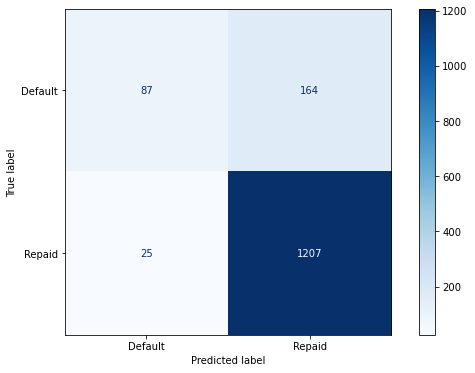

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

plot_confusion_matrix(model, X_train, y_train,
                      ax=ax, cmap=plt.cm.Blues,
                      labels=[1, 0],
                      display_labels=['Default', 'Repaid']);

**Reporte en Evaluación**

In [12]:
y_test_pred = model.predict(X_test)

print(classification_report(y_test, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       313
           1       0.74      0.34      0.47        58

    accuracy                           0.88       371
   macro avg       0.82      0.66      0.70       371
weighted avg       0.87      0.88      0.86       371



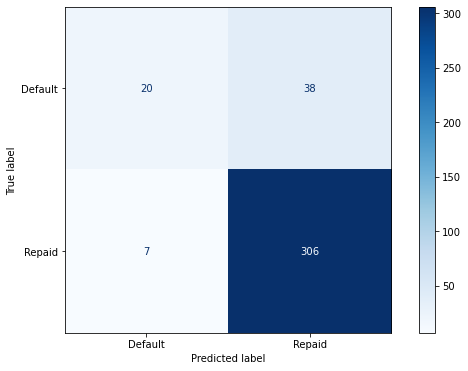

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

plot_confusion_matrix(model, X_test, y_test,
                      ax=ax, cmap=plt.cm.Blues,
                      labels=[1, 0],
                      display_labels=['Default', 'Repaid']);

**Observaciones**

- El *recall* (para la categoría **1**) parece ser la métrica más baja, **0.34** en evaluación y **0.35** en entrenamiento.

- El *recall* (para la categoría **0**) parece ser la métrica más alta, **0.98** en evaluación y **0.98** en entrenamiento.

Una justificación para este fenómeno puede ser el desbalanceo de clases (hay mucha mayor cantidad de datos de la clase **0**, que de la clase **1**), por lo que el modelo tiende a predecir la clase mayoritaria.

### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del `SGDClassifier`. Como mínimo, probar diferentes funciones de pérdida (`loss`), tasas de entrenamiento (`alpha`), y tasas de regularización (`penalty`).

Para ello, usar *grid-search* y *5-fold cross-validation* sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar *accuracy* promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- Matriz de Confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [14]:
param_grid = {
    'loss': ['hinge', 'perceptron', 'log'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'penalty': ['l2', 'l1', 'elasticnet'],
}

In [15]:
model = SGDClassifier(max_iter=10000, random_state=0)

cv = GridSearchCV(model, param_grid, scoring='accuracy', cv=5)
cv.fit(X_train, y_train);

**Observación**

El *warning* `ConvergenceWarning: Maximum number of iteration reached before convergence.` se produce al no converger en una cantidad máxima de pasos de aprendizaje.
Es decir, el algoritmo finaliza por alcanzar el límite de pasos y no haber encontrado un mínimo local.

In [16]:
# Obtenemos los resultados de la VC sobre la Grilla de Parámetros.
results = cv.cv_results_

cols = [
    'param_loss',
    'param_alpha',
    'param_penalty',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
]

df = pd.DataFrame(results, columns=cols)

df

,param_loss,param_alpha,param_penalty,mean_test_score,std_test_score,rank_test_score
0,hinge,0.0001,l2,0.868514,0.008732,2
1,hinge,0.0001,l1,0.869190,0.014962,1
2,hinge,0.0001,elasticnet,0.865809,0.006613,3
3,perceptron,0.0001,l2,0.717188,0.272492,37
4,perceptron,0.0001,l1,0.861778,0.012507,6
5,perceptron,0.0001,elasticnet,0.632050,0.283379,43
6,log,0.0001,l2,0.861766,0.012620,7
7,log,0.0001,l1,0.863798,0.014815,5
8,log,0.0001,elasticnet,0.861091,0.013406,9
9,hinge,0.001,l2,0.847609,0.003162,15


**Análisis del Mejor Modelo**

In [17]:
cv.best_params_

{'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l1'}

In [18]:
best_model = cv.best_estimator_

best_model.fit(X_train, y_train);

**Reporte en Entrenamiento**

In [19]:
y_train_pred = best_model.predict(X_train)

print(classification_report(y_train, y_train_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1232
           1       0.81      0.31      0.45       251

    accuracy                           0.87      1483
   macro avg       0.85      0.65      0.69      1483
weighted avg       0.87      0.87      0.85      1483



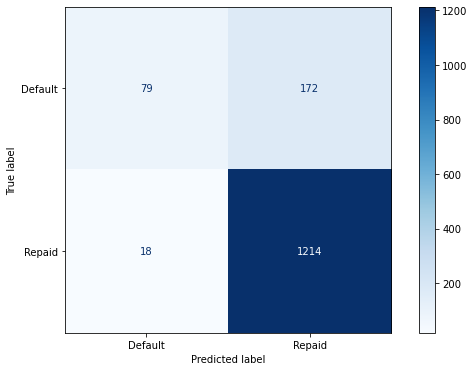

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

plot_confusion_matrix(best_model, X_train, y_train,
                      ax=ax, cmap=plt.cm.Blues,
                      labels=[1, 0],
                      display_labels=['Default', 'Repaid']);

**Reporte en Evaluación**

In [21]:
y_test_pred = best_model.predict(X_test)

print(classification_report(y_test, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       313
           1       0.81      0.29      0.43        58

    accuracy                           0.88       371
   macro avg       0.85      0.64      0.68       371
weighted avg       0.87      0.88      0.85       371



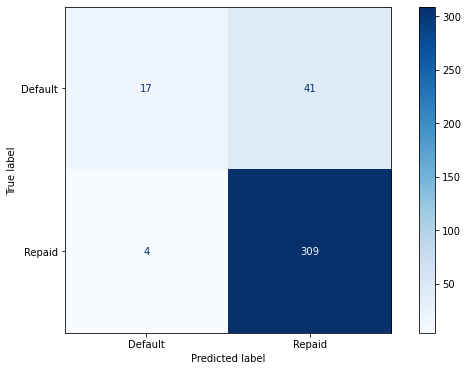

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

plot_confusion_matrix(best_model, X_test, y_test,
                      ax=ax, cmap=plt.cm.Blues,
                      labels=[1, 0],
                      display_labels=['Default', 'Repaid']);

**Observaciones**

Utilizando la búsqueda de parámetros, obtuvimos resultados similares a los conseguidos con el modelo con parámetros por defecto.

El *recall* (para la categoría **1**) obtenido es inferior a los anteriores, en entrenamiento *0.31* y en evaluación *0.29*.

El único parámetro que varió fue el `penalty`, donde en lugar de utilizar *l2* se eligió *l1* (en `alpha` se mantiene *0.0001*, y en `loss` se mantiene *hinge*).

## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase `DecisionTreeClassifier` de *scikit-learn*.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

In [23]:
# División entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador `DecisionTreeClassifier` usando los valores por omisión de *scikit-learn* para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- Matriz de Confusión

In [24]:
model = DecisionTreeClassifier(random_state=0)

model.fit(X_train, y_train);

**Reporte en Entrenamiento**

In [25]:
y_train_pred = model.predict(X_train)

print(classification_report(y_train, y_train_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1232
           1       1.00      1.00      1.00       251

    accuracy                           1.00      1483
   macro avg       1.00      1.00      1.00      1483
weighted avg       1.00      1.00      1.00      1483



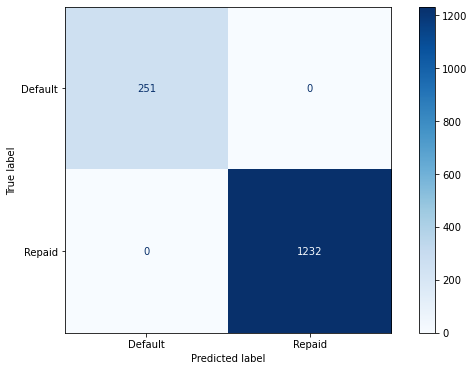

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

plot_confusion_matrix(model, X_train, y_train,
                      ax=ax, cmap=plt.cm.Blues,
                      labels=[1, 0],
                      display_labels=['Default', 'Repaid']);

**Reporte en Evaluación**

In [27]:
y_test_pred = model.predict(X_test)

print(classification_report(y_test, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       313
           1       0.62      0.64      0.63        58

    accuracy                           0.88       371
   macro avg       0.77      0.78      0.78       371
weighted avg       0.88      0.88      0.88       371



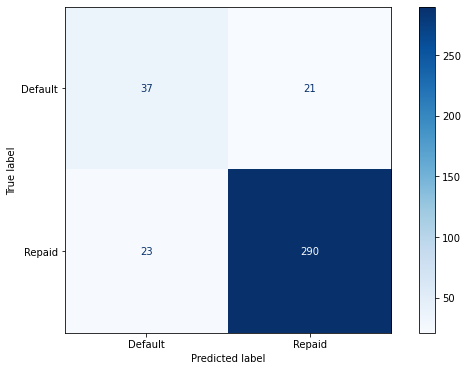

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))

plot_confusion_matrix(model, X_test, y_test,
                      ax=ax, cmap=plt.cm.Blues,
                      labels=[1, 0],
                      display_labels=['Default', 'Repaid']);

**Visualización del Árbol**

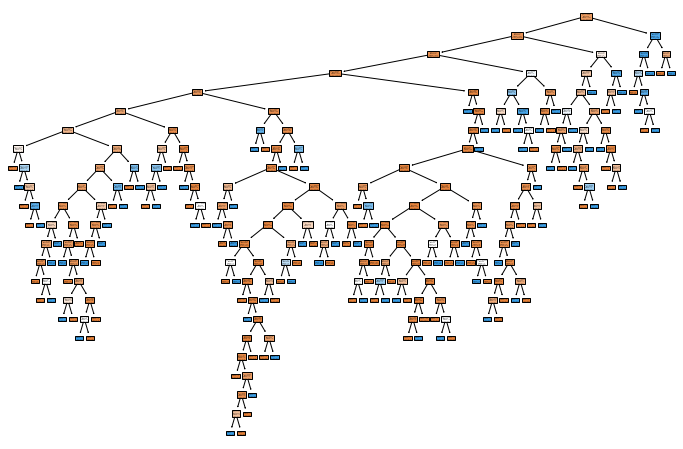

In [29]:
fig = plt.figure(figsize=(12, 8))

plot_tree(model, filled=True);

In [30]:
# Profundidad
model.get_depth()

22

**Observaciones**

En esta sección podemos observar una serie de características.

- En el entrenamiento hubo *sobreajuste* ya que se obtuvo una *exactitud* (*accuracy*) del 100%.
- Incluso con este sobreajuste, y los parámetros por defecto, se obtuvo una generalización levemente mejor (44 errores de test contra 45 errores de test) a los modelos anteriores que utilizaban *descenso de gradiente estocástico*.
- Se obtuvo un árbol complejo, con profundida máxima (22), el cual puede ser complicado de interpretar.

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del `DecisionTreeClassifier`. Como mínimo, probar diferentes criterios de partición (`criterion`), profundidad máxima del árbol (`max_depth`), y cantidad mínima de samples por hoja (`min_samples_leaf`).

Para ello, usar *grid-search* y *5-fold cross-validation* sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar *accuracy* promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- Matriz de Confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [31]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 5, 10, 20, None],
    'min_samples_leaf': [1, 2, 3, 4, 5, 10],
}

In [32]:
model = DecisionTreeClassifier(random_state=0)

cv = GridSearchCV(model, param_grid, scoring='accuracy', cv=5)
cv.fit(X_train, y_train);

In [33]:
# Obtenemos los resultados de la VC sobre la Grilla de Parámetros.
results = cv.cv_results_

cols = [
    'param_criterion',
    'param_max_depth',
    'param_min_samples_leaf',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
]

df = pd.DataFrame(results, columns=cols)

df

,param_criterion,param_max_depth,param_min_samples_leaf,mean_test_score,std_test_score,rank_test_score
0,gini,1,1,0.869194,0.009254,29
1,gini,1,2,0.869194,0.009254,29
2,gini,1,3,0.869194,0.009254,29
3,gini,1,4,0.869194,0.009254,29
4,gini,1,5,0.869194,0.009254,29
5,gini,1,10,0.869194,0.009254,29
6,gini,5,1,0.874584,0.014342,16
7,gini,5,2,0.874584,0.014342,16
8,gini,5,3,0.874586,0.015238,15
9,gini,5,4,0.873239,0.015548,19


**Análisis del Mejor Modelo**

In [34]:
cv.best_params_

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2}

In [35]:
best_model = cv.best_estimator_

best_model.fit(X_train, y_train);

**Reporte en Entrenamiento**

In [36]:
y_train_pred = best_model.predict(X_train)

print(classification_report(y_train, y_train_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1232
           1       0.99      0.71      0.83       251

    accuracy                           0.95      1483
   macro avg       0.97      0.86      0.90      1483
weighted avg       0.95      0.95      0.95      1483



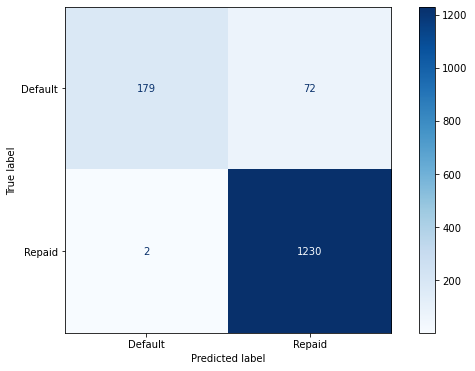

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))

plot_confusion_matrix(best_model, X_train, y_train,
                      ax=ax, cmap=plt.cm.Blues,
                      labels=[1, 0],
                      display_labels=['Default', 'Repaid']);

**Reporte en Evaluación**

In [38]:
y_test_pred = best_model.predict(X_test)

print(classification_report(y_test, y_test_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       313
           1       0.75      0.52      0.61        58

    accuracy                           0.90       371
   macro avg       0.83      0.74      0.78       371
weighted avg       0.89      0.90      0.89       371



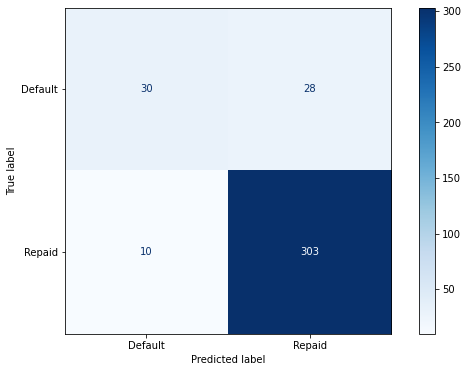

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))

plot_confusion_matrix(best_model, X_test, y_test,
                      ax=ax, cmap=plt.cm.Blues,
                      labels=[1, 0],
                      display_labels=['Default', 'Repaid']);

**Visualización del Árbol**

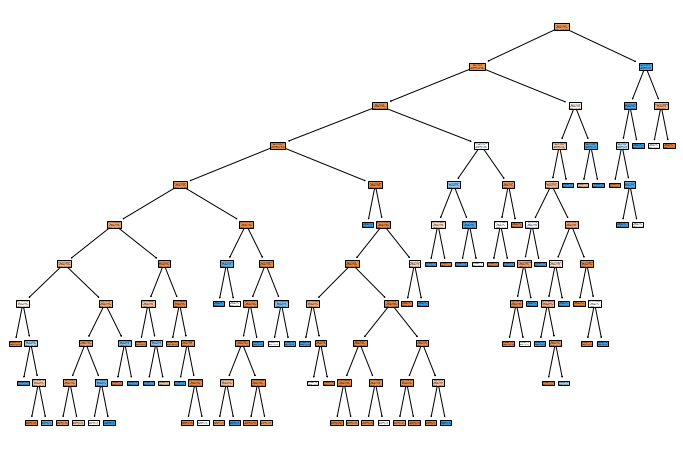

In [40]:
fig = plt.figure(figsize=(12, 8))

plot_tree(best_model, filled=True);

In [41]:
# Profundidad
best_model.get_depth()

10

**Observaciones**

En la búsqueda de hiperparámetros podemos observar una serie de características.

- Los parámetros obtenidos son `criterion` con *gini*, `max_depth` con *10*, y `min_samples_leaf` con *2*.
- En el entrenamiento **no** hubo *sobreajuste*, donde se obtuvo una *exactitud* (*accuracy*) del 95%.
- Se obtuvo la mejor generalización del laboratorio con 90% de *exactitud* (*accuracy*) en el conjunto de evaluación.
- Se obtuvo un árbol más simple al anterior, con profundidad 10, el cual resulta más fácil de interpretar.